In [ ]:
from google.colab import drive
drive.mount('./mount')

Drive already mounted at ./mount; to attempt to forcibly remount, call drive.mount("./mount", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Data load

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
d_cell = pd.read_csv('/home/sbml/BADA/cells_features.csv')
d_module = pd.read_csv('/home/sbml/BADA/7p_features.csv')

In [ ]:
features = d_cell.columns[1:-1]
print(len(features))
features

62


Index(['dis_v_start', 'dis_v_time', 'dis_v_end', 'dis_v_area', 'dis_v_slope',
       'dis_v_std', 'dis_v_skew', 'dis_v_kur', 'dis_curr_slope',
       'dis_ic_start', 'dis_ic_start_volt', 'dis_ic_end', 'dis_ic_end_volt',
       'dis_ic_area', 'dis_ic_std', 'dis_ic_skew', 'dis_ic_kur',
       'dis_ic_peak1', 'dis_ic_peak1_volt', 'dis_ic_peak2',
       'dis_ic_peak2_volt', 'dis_ic_peak3', 'dis_ic_peak3_volt',
       'dis_ic_min_peak1', 'dis_ic_min_peak1_volt', 'dis_ic_min_peak2',
       'dis_ic_min_peak2_volt', 'v_start', 'v_area', 'v_slope', 'v_std',
       'v_skew', 'v_kurtosis', 'v_noplat_end', 'v_noplat_area',
       'v_noplat_slope', 'v_noplat_std', 'v_noplat_skew', 'v_noplat_kurtosis',
       'I_noplat_start', 'I_noplat_start_time', 'I_noplat_end',
       'I_noplat_end_time', 'I_noplat_area', 'I_noplat_slope', 'I_noplat_skew',
       'I_noplat_kurtosis', 'ic_start', 'ic_area', 'ic_std', 'ic_skew',
       'ic_kurtosis', 'ic_peak1', 'ic_peak1_volt', 'ic_peak2', 'ic_peak2_volt',
      

# Model architecture

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Sequential

In [ ]:
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))

    sines = np.sin(angle_rads[:, 0::2])
    cosines = np.cos(angle_rads[:, 1::2])

    pos_encoding = np.concatenate([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
def encoder_block(num_layer, x, drop1, drop2, dff, d_model):
  heads = 8
  n = d_model//heads  # num_heads=heads
  i = num_layer

  ## mulit_head_attention (sublayer 1)
  norm1 = layers.LayerNormalization(epsilon=1e-6,name=f'layer_norm1_{i+1}')(x)
  attention_output, attention_weight = layers.MultiHeadAttention(num_heads=heads, key_dim=n, value_dim=n, dropout=drop1, name=f'mulit_head{i+1}')(query=norm1, key=norm1, value=norm1, return_attention_scores=True)
  x = layers.Add(name=f'residual_connection1_{i+1}')([x, attention_output])

  ## feed_forward (sublayer 2)
  norm2  = layers.LayerNormalization(epsilon=1e-6, name=f'layer_norm2_{i+1}')(x)
  ffn = layers.Dense(dff, activation='gelu', name=f'FFN1_{i+1}')(norm2)
  ffn = layers.Dense(d_model, name=f'FFN2_{i+1}')(ffn)
  ffn = layers.Dropout(rate=drop2)(ffn)
  x = layers.Add(name=f'residual_connection2_{i+1}')([x, ffn])
  return x, attention_weight

In [ ]:
def estimator(seq_len, input_dim, d_model, drop1, drop2, dff, reg_fc):
  ## input embedding
  inputs = layers.Input(shape=(seq_len,), name='inputs')
  embedding = layers.Embedding(input_dim=input_dim, output_dim=d_model, name='input_embedding')(inputs)

  ## positional encoding
  pos_enc = positional_encoding(seq_len, d_model)

  x = embedding + pos_enc

  ## encoders
  attention_weight_l = []
  for i in range(4):
    x, attention_weight = encoder_block(i, x, drop1, drop2, dff, d_model)
    attention_weight_l.append(attention_weight)

  ## regression
  pool = layers.GlobalAveragePooling1D()(x)
  outputs = layers.Dense(reg_fc, activation='relu', name='FC1')(pool)
  outputs = layers.Dense(1, name='FC2')(outputs)

  model = tf.keras.Model(inputs=inputs, outputs=[outputs, attention_weight_l])
  model.summary()
  return model

In [ ]:
def classifier(seq_len, input_dim, d_model, drop1, drop2, dff, reg_fc):
  ## input embedding
  inputs = layers.Input(shape=(seq_len,), name='inputs')
  embedding = layers.Embedding(input_dim=input_dim, output_dim=d_model, name='input_embedding')(inputs)

  ## positional encoding
  pos_enc = positional_encoding(seq_len, d_model)

  x = embedding + pos_enc

  ## encoders
  attention_weight_l = []
  for i in range(4):
    x, attention_weight = encoder_block(i, x, drop1, drop2, dff, d_model)
    attention_weight_l.append(attention_weight)

  ## classification
  pool = layers.GlobalAveragePooling1D()(x)
  #outputs = layers.Dense(reg_fc1, name='FC1')(pool)
  outputs = layers.Dense(reg_fc, activation='relu', name='FC1')(pool)
  outputs = layers.Dense(1, activation='sigmoid', name='FC2')(outputs)

  model = tf.keras.Model(inputs=inputs, outputs=[outputs, attention_weight_l])
  model.summary()
  return model

# SoH estimator

## 0. data split

In [ ]:
cell = d_cell[features].values
module = d_module[features].values

cell_soh = d_cell[['soh']].values
module_soh = d_module[['soh']].values

In [ ]:
def labeled_soh(soh):
  soh_l = []
  for i in soh:
    if 0.95 <= i <= 1:
      soh_l.append(1)
    elif 0.9 <= i < 0.95:
      soh_l.append(2)
    elif 0.85 <= i < 0.9:
      soh_l.append(3)
    elif 0.8 <= i < 0.85:
      soh_l.append(4)
    elif 0.75 <= i < 0.8:
      soh_l.append(5)
    elif 0.7 <= i < 0.75:
      soh_l.append(6)
    else:
      soh_l.append(7)

  label_l = np.array(soh_l)
  return label_l

In [ ]:
def data_split(X, label_l, y, rate):
  sss = StratifiedShuffleSplit(n_splits=5, test_size=rate)
  for train_index, test_index in sss.split(X, label_l):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
  label_test_l = label_l[test_index]
  return X_train, y_train, X_test, y_test,label_test_l

In [ ]:
label_l = labeled_soh(cell_soh)

X_train, y_train, X_test, y_test, label_test_l = data_split(cell, label_l, cell_soh, 0.2)
X_test_f, y_test_f, X_val, y_val, _ = data_split(X_test, label_test_l, y_test, 0.5)


X_train, y_train = X_train, y_train
X_test, y_test = X_test_f, y_test_f
X_val, y_val = X_val, y_val

In [ ]:
d_test = pd.DataFrame(X_test, columns=features)
d_test['soh'] = y_test
d_test.to_csv('/home/sbml/BADA/reg_test_data.csv', index=False)

In [ ]:
X_train.shape, X_test.shape, X_val.shape

((2032, 62), (254, 62), (254, 62))

## 1. model train

In [ ]:
input_dim = 128

In [ ]:
reg_model = estimator(seq_len=62, input_dim=input_dim, d_model=64, drop1=0.1, drop2=0.1, dff=256, reg_fc=16)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)       │ (None, 62)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_embedding           │ (None, 62, 64)         │          8,192 │ inputs[0][0]           │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 62, 64)         │              0 │ input_embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_norm1_1             │ (None, 62, 64)         │            128 │ add_5[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mulit_head1               │ [(None, 62, 64),       │         16,640 │ layer_norm1_1[0][0],   │
│ (MultiHeadAttention)      │ (None, 8, 62, 62)]     │                │ layer_norm1_1[0][0],   │
│                           │                        │                │ layer_norm1_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_connection1_1    │ (None, 62, 64)         │              0 │ add_5[0][0],           │
│ (Add)                     │                        │                │ mulit_head1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_norm2_1             │ (None, 62, 64)         │            128 │ residual_connection1_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ FFN1_1 (Dense)            │ (None, 62, 256)        │         16,640 │ layer_norm2_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ FFN2_1 (Dense)            │ (None, 62, 64)         │         16,448 │ FFN1_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_65 (Dropout)      │ (None, 62, 64)         │              0 │ FFN2_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_connection2_1    │ (None, 62, 64)         │              0 │ residual_connection1_… │
│ (Add)                     │                        │                │ dropout_65[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_norm1_2             │ (None, 62, 64)         │            128 │ residual_connection2_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mulit_head2               │ [(None, 62, 64),       │         16,640 │ layer_norm1_2[0][0],   │
│ (MultiHeadAttention)      │ (None, 8, 62, 62)]     │                │ layer_norm1_2[0][0],   │
│                           │                        │                │ layer_norm1_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_connection1_2    │ (None, 62, 64)         │              0 │ residual_connection2_… │
│ (Add)                     │                        │                │ mulit_head2[0][0]      │
├──────────────────────

 Total params: 209,185 (817.13 KB)

 Trainable params: 209,185 (817.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min', baseline=None, restore_best_weights=True)

In [ ]:
epochs=50
batch_size=64
adam = optimizers.Adam()
reg_model.compile(loss=['mean_squared_error', None], optimizer = adam)
hist = reg_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data = (X_val, y_val), callbacks=[early_stopping])  #, callbacks=[early_stopping]
hist

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 385ms/step - loss: 0.4708 - val_loss: 0.0074
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0098 - val_loss: 0.0058
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074 - val_loss: 0.0043
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054 - val_loss: 0.0030
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0044 - val_loss: 0.0034
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - val_loss: 9.0805e-04
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - val_loss: 3.9949e-04
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - val_loss: 4.9930e-04
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - val_loss: 3.5808e-04
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - val_loss: 4.0539e-04
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

In [ ]:
score = reg_model.evaluate(X_test, y_test, verbose=1)
print('Test loss: ', score)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 1.6134e-04
Test loss:  0.00013352248060982674


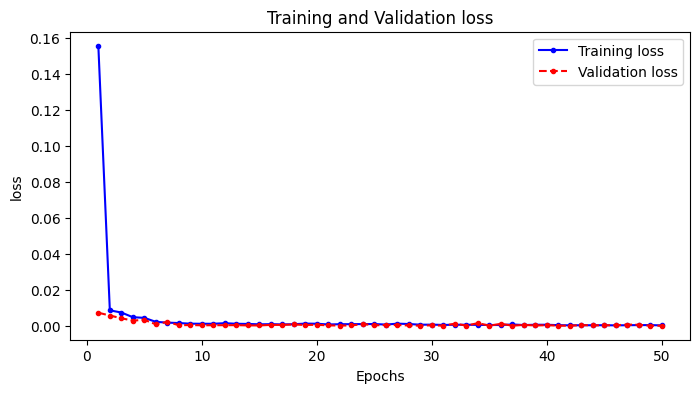

In [ ]:
plt.figure(figsize=(8,4))
n = range(1, len(hist.history['loss'])+1)
plt.plot(n,hist.history['loss'], 'b', marker='.', label='Training' + ' loss')
plt.plot(n,hist.history['val_loss'], 'r--', marker='.', label='Validation' + ' loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

## 2. model test

### applied to the trained cell



In [ ]:
c_pred, att_W = reg_model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step


Text(0.5, 1.0, 'Before Feature Selection')

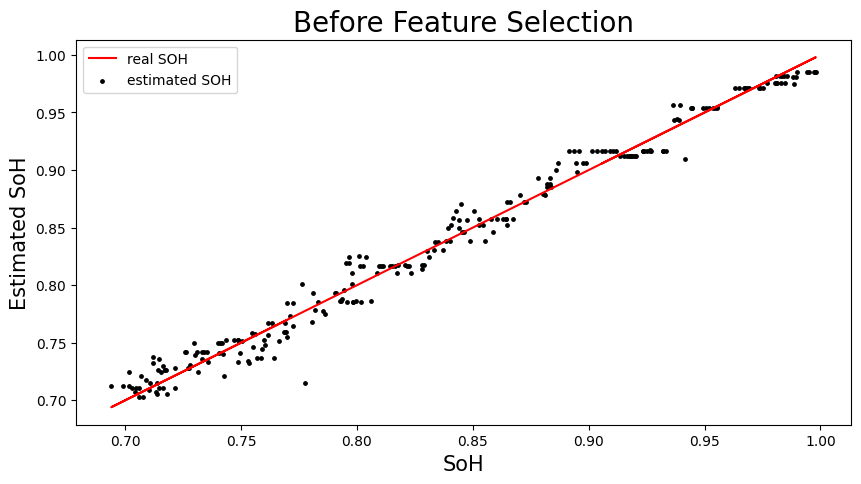

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(y_test, y_test, color='r', label='real SOH')
plt.scatter(y_test, c_pred, color='black', s=6, label = 'estimated SOH')
plt.legend()
plt.xlabel('SoH', size=15)
plt.ylabel('Estimated SoH', size=15)
plt.title('Before Feature Selection', size=20)

In [ ]:
r2 = r2_score(y_test, c_pred)
rmse = mean_squared_error(y_test, c_pred)**0.5
mse = mean_squared_error(y_test, c_pred)
mae = mean_absolute_error(y_test, c_pred)
mape = mean_absolute_percentage_error(y_test, c_pred)
print(r2)
print(rmse)

0.9830360848692564
0.011555193314326124


### applied to a 7P module



In [ ]:
X_module = d_module[features].values
y_module = d_module[['soh']].values

In [ ]:
np.min(X_module), np.max(X_module)

(-6.197003052323881, 863077.2489999998)

In [ ]:
m_pred, att_W = reg_model.predict(X_module)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


Text(0.5, 1.0, 'Before Feature Selection')

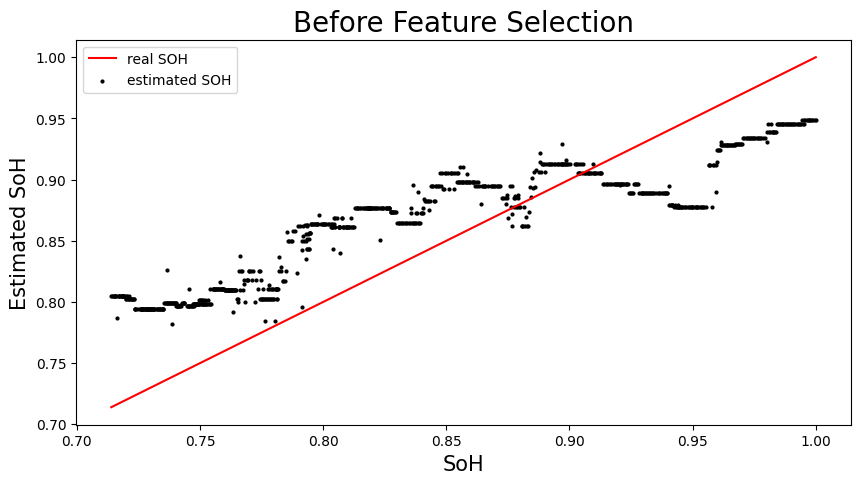

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(y_module, y_module, color='r', label='real SOH')
plt.scatter(y_module, m_pred, color='black', s=4, label = 'estimated SOH')
plt.legend()
plt.xlabel('SoH', size=15)
plt.ylabel('Estimated SoH', size=15)
plt.title('Before Feature Selection', size=20)

In [ ]:
r2 = r2_score(y_module, m_pred)
rmse = mean_squared_error(y_module, m_pred)**0.5
mse = mean_squared_error(y_module, m_pred)
mae = mean_absolute_error(y_module, m_pred)
mape = mean_absolute_percentage_error(y_module, m_pred)
print(r2)
print(rmse)

0.6540565040834808
0.04948679250008822


# Configuration classifier

## 0. data split

In [ ]:
cell = d_cell[features].values
module = d_module[features].values

In [ ]:
c_label = np.array([0]*len(cell))
m_label = np.array([1]*len(module))

raw_X = np.vstack([cell, module])
raw_y = np.hstack([c_label, m_label]).reshape(-1,1)
label_raw_l = labeled_soh(raw_y)

In [ ]:
X_remain, y_remain, X, y, label_l = data_split(raw_X, label_raw_l, raw_y, 0.6)
X.shape

(2033, 62)

In [ ]:
X = raw_X
y = raw_y
label_l = label_raw_l

In [ ]:
X_train, y_train, X_test, y_test, label_test_l = data_split(X, label_l, y, 0.2)
X_test_f, y_test_f, X_val, y_val, _ = data_split(X_test, label_test_l, y_test, 0.5)

X_train, y_train = X_train, y_train
X_test, y_test = X_test_f, y_test_f
X_val, y_val = X_val, y_val

In [ ]:
d_test = pd.DataFrame(X_test, columns=features)
d_test['soh'] = y_test
d_test.to_csv('/home/sbml/BADA/clf_test_data.csv', index=False)

## 1. model train

In [ ]:
input_dim

128

In [ ]:
clf_model = classifier(seq_len=62, input_dim=input_dim, d_model=64, drop1=0.1, drop2=0.1, dff=256, reg_fc=16)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)       │ (None, 62)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_embedding           │ (None, 62, 64)         │          8,192 │ inputs[0][0]           │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 62, 64)         │              0 │ input_embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_norm1_1             │ (None, 62, 64)         │            128 │ add_7[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mulit_head1               │ [(None, 62, 64),       │         16,640 │ layer_norm1_1[0][0],   │
│ (MultiHeadAttention)      │ (None, 8, 62, 62)]     │                │ layer_norm1_1[0][0],   │
│                           │                        │                │ layer_norm1_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_connection1_1    │ (None, 62, 64)         │              0 │ add_7[0][0],           │
│ (Add)                     │                        │                │ mulit_head1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_norm2_1             │ (None, 62, 64)         │            128 │ residual_connection1_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ FFN1_1 (Dense)            │ (None, 62, 256)        │         16,640 │ layer_norm2_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ FFN2_1 (Dense)            │ (None, 62, 64)         │         16,448 │ FFN1_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_81 (Dropout)      │ (None, 62, 64)         │              0 │ FFN2_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_connection2_1    │ (None, 62, 64)         │              0 │ residual_connection1_… │
│ (Add)                     │                        │                │ dropout_81[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_norm1_2             │ (None, 62, 64)         │            128 │ residual_connection2_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mulit_head2               │ [(None, 62, 64),       │         16,640 │ layer_norm1_2[0][0],   │
│ (MultiHeadAttention)      │ (None, 8, 62, 62)]     │                │ layer_norm1_2[0][0],   │
│                           │                        │                │ layer_norm1_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_connection1_2    │ (None, 62, 64)         │              0 │ residual_connection2_… │
│ (Add)                     │                        │                │ mulit_head2[0][0]      │
├──────────────────────

 Total params: 209,185 (817.13 KB)

 Trainable params: 209,185 (817.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs=3
batch_size=64
adam = optimizers.Adam()
clf_model.compile(loss=['binary_crossentropy', None], optimizer = adam, metrics=['acc', [],[],[],[]])
hist = clf_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data = [X_val, y_val])
hist

Epoch 1/3
43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 309ms/step - FC2_acc: 0.7338 - loss: 0.6514 - val_FC2_acc: 0.7493 - val_loss: 0.5393
Epoch 2/3
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - FC2_acc: 0.7688 - loss: 0.4963 - val_FC2_acc: 0.9410 - val_loss: 0.1324
Epoch 3/3
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - FC2_acc: 0.9941 - loss: 0.0228 - val_FC2_acc: 1.0000 - val_loss: 1.7818e-05


In [ ]:
reg_model.save('/home/sbml/BADA/model/reg_model.keras')
clf_model.save('/home/sbml/BADA/model/clf_model.keras')